<a href="https://colab.research.google.com/github/Dansato1203/soccerfield_detector/blob/master/scripts/SoccerField_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Dataset_dir = '/content/gdrive/MyDrive/設計製作論5/test_1'
val_dataset_dir = '/content/gdrive/MyDrive/設計製作論5/test_2'
test_img1 = '/content/gdrive/MyDrive/設計製作論5/test_2/000757.jpg'
test_img2 = '/content/gdrive/MyDrive/設計製作論5/test_2/000670.jpg'
weight_name = 'field_detector.pt'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
import numpy as np
import argparse
import glob
import os

IMW = 320
IMH = 240

import matplotlib.pyplot as plt

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_units1, n_units2):
        super(MLP, self).__init__()
        self.l1 = nn.Conv2d(3, n_units1, 5, stride=1, padding=2)
        #self.l2 = nn.Conv2d(n_units1, n_units2, 3, stride=1, padding=1)
        self.l3 = nn.Conv2d(n_units1, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = F.relu(self.l1(x))
        #x = F.relu(self.l2(x))
        x = self.l3(x)
        return torch.sigmoid(x)
        #return x

In [ ]:
def load_image(fname, imw, imh):
    img = Image.open(fname).resize((imw, imh))

    a = np.asarray(img).transpose(2,0,1).astype(np.float32)/255.
    return a, img

In [ ]:
def png2array(lfile_array, imw, imh):
  a = np.zeros((3, imh, imw), dtype=np.float32)
  for x in range(imw):
    for y in range(imh):
      if (lfile_array[y][x] == 1):
        a[0][y][x] = 1
      elif (lfile_array[y][x] == 50):
        a[1][y][x] = 1
  return a

In [ ]:
class SoccerFieldDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        imw = IMW
        imh = IMH
        x = np.zeros((0, 3, imh, imw), dtype=np.float32)
        t = np.zeros((0, 3, imh, imw), dtype=np.float32)
        jpgfiles = glob.glob(image_dir + '*.jpg')
        print(jpgfiles)
        for f in jpgfiles:
            plt.figure()
            a, img = load_image(f, imw, imh)
            a1 = np.expand_dims(a,axis=0)
            x = np.append(x, a1, axis=0)
           
            plt.imshow(img)
            
            lfile = os.path.splitext(f)[0] + '_label.png'
            print(lfile)
            img = Image.open(lfile).resize((imw, imh))
            
            plt.figure()
            plt.imshow(img)
            
            a = np.asarray(img).astype(np.float32)
            a = a.astype(np.int32)
            #print(np.sum(a))
            a = png2array(a, imw, imh)
            a1 = np.expand_dims(a,axis=0)
            t = np.append(t, a1, axis=0)
        
        self.data  = x
        self.label = t
        #print(self.data.shape)
        print(self.label.shape)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #print(self.data.shape)
        #print(self.label.shape)
        images = self.data[idx, :, :, :]
        labels = self.label[idx, :, :]

        #print(f"images: {images}")
        #rint(f"labels: {labels}")

        return (images, labels)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args(args=[])

['/content/gdrive/MyDrive/設計製作論5/test_1/000435.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000540.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000480.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000200.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000270.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000051.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000333.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000660.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000650.jpg', '/content/gdrive/MyDrive/設計製作論5/test_1/000600.jpg']
/content/gdrive/MyDrive/設計製作論5/test_1/000435_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000540_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000480_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000200_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000270_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000051_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000333_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/000660_label.png
/content/gdrive/MyDrive/設計製作論5/test_1/0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


/content/gdrive/MyDrive/設計製作論5/test_2/000670_label.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/content/gdrive/MyDrive/設計製作論5/test_2/000757_label.png
(2, 3, 240, 320)


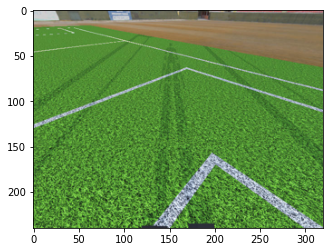

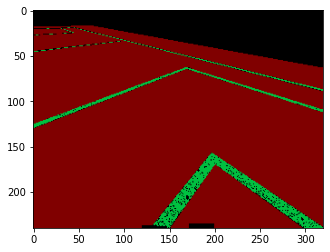

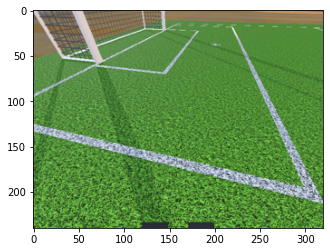

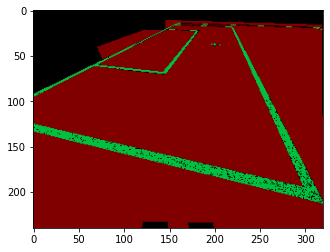

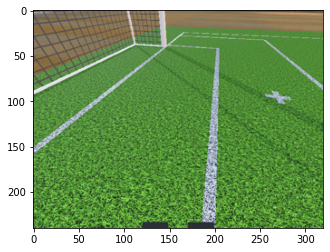

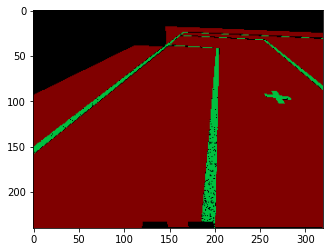

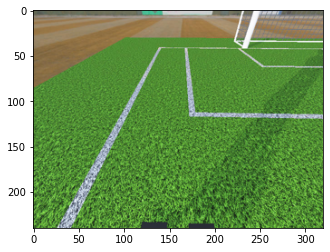

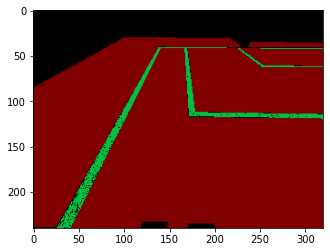

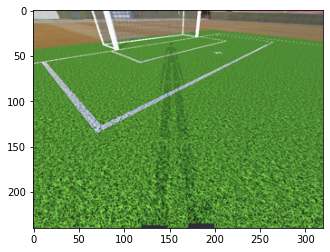

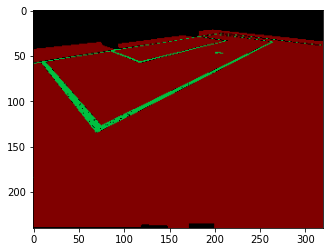

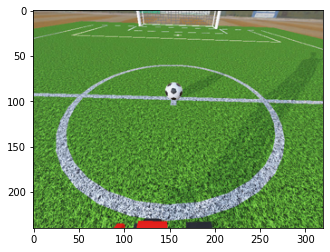

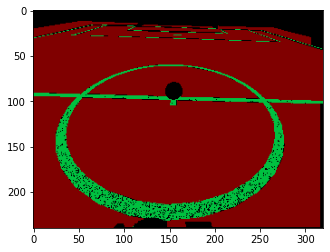

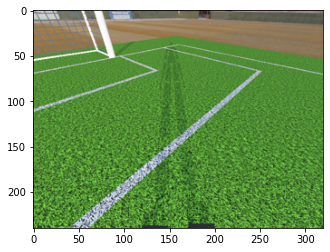

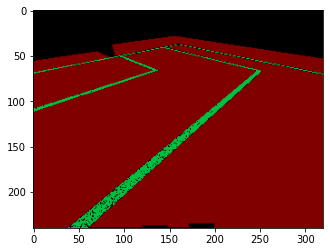

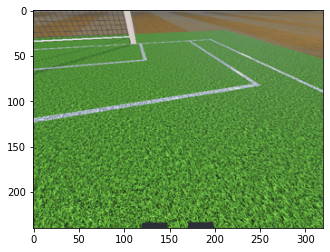

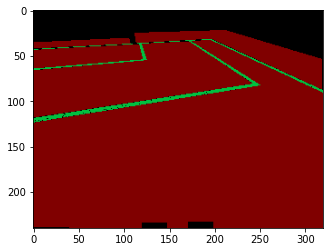

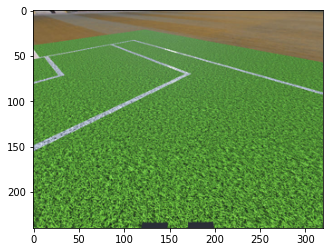

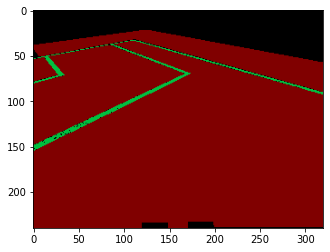

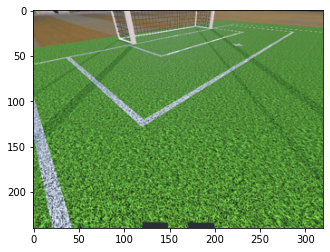

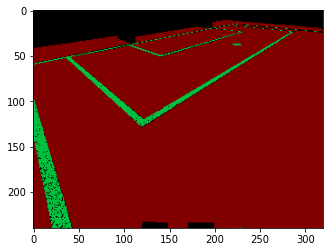

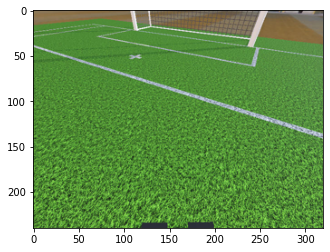

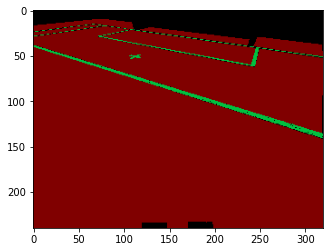

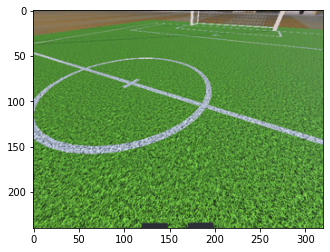

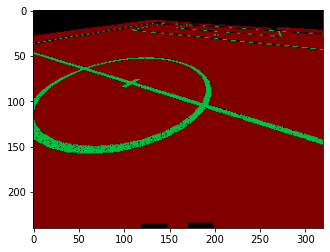

In [ ]:
dataset = SoccerFieldDataset(Dataset_dir + '/')
val_dataset = SoccerFieldDataset(val_dataset_dir + '/')
train_loader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=0)

In [ ]:
# exec training
def train(args, model, device, dataloader, optimizer, epoch):
    model.train()
    lossfun = nn.BCELoss()
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = lossfun(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            loss_list.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))
            if args.dry_run:
                break

# valid
def valid(args, model, device, dataloader, epoch):
    with torch.no_grad():
        model.eval()
        loss_fun = nn.BCELoss()
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fun(output, target)
            if batch_idx % args.log_interval == 0:
                  val_loss_list.append(loss.item())
                  if args.dry_run:
                      break

model = MLP(4, 3).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr, weight_decay=0.001)
model.to(device)

# 繰り返し数は要調整
# Lossが0.05くらいまで下がるはず（下がらなかったらやり直す）
loss_list = []
val_loss_list = []
for i in range(1500):
    train(args, model=model, device=device, dataloader=train_loader, optimizer=optimizer, epoch=i)
    valid(args, model=model, device=device, dataloader=val_loader, epoch=i)


# save to file
cpu = torch.device("cpu")
model.to(cpu)
torch.save(model.state_dict(), "wl_model.pt")

Train Epoch: 0 [0/10 (0%)]	Loss: 0.616695
Train Epoch: 1 [0/10 (0%)]	Loss: 0.606442
Train Epoch: 2 [0/10 (0%)]	Loss: 0.592291
Train Epoch: 3 [0/10 (0%)]	Loss: 0.577276
Train Epoch: 4 [0/10 (0%)]	Loss: 0.560171
Train Epoch: 5 [0/10 (0%)]	Loss: 0.534916
Train Epoch: 6 [0/10 (0%)]	Loss: 0.512893
Train Epoch: 7 [0/10 (0%)]	Loss: 0.489909
Train Epoch: 8 [0/10 (0%)]	Loss: 0.464538
Train Epoch: 9 [0/10 (0%)]	Loss: 0.437201
Train Epoch: 10 [0/10 (0%)]	Loss: 0.409546
Train Epoch: 11 [0/10 (0%)]	Loss: 0.384770
Train Epoch: 12 [0/10 (0%)]	Loss: 0.364785
Train Epoch: 13 [0/10 (0%)]	Loss: 0.342669
Train Epoch: 14 [0/10 (0%)]	Loss: 0.328715
Train Epoch: 15 [0/10 (0%)]	Loss: 0.301506
Train Epoch: 16 [0/10 (0%)]	Loss: 0.297982
Train Epoch: 17 [0/10 (0%)]	Loss: 0.272837
Train Epoch: 18 [0/10 (0%)]	Loss: 0.270766
Train Epoch: 19 [0/10 (0%)]	Loss: 0.266131
Train Epoch: 20 [0/10 (0%)]	Loss: 0.261720
Train Epoch: 21 [0/10 (0%)]	Loss: 0.252576
Train Epoch: 22 [0/10 (0%)]	Loss: 0.252056
Train Epoch: 23 [0/10

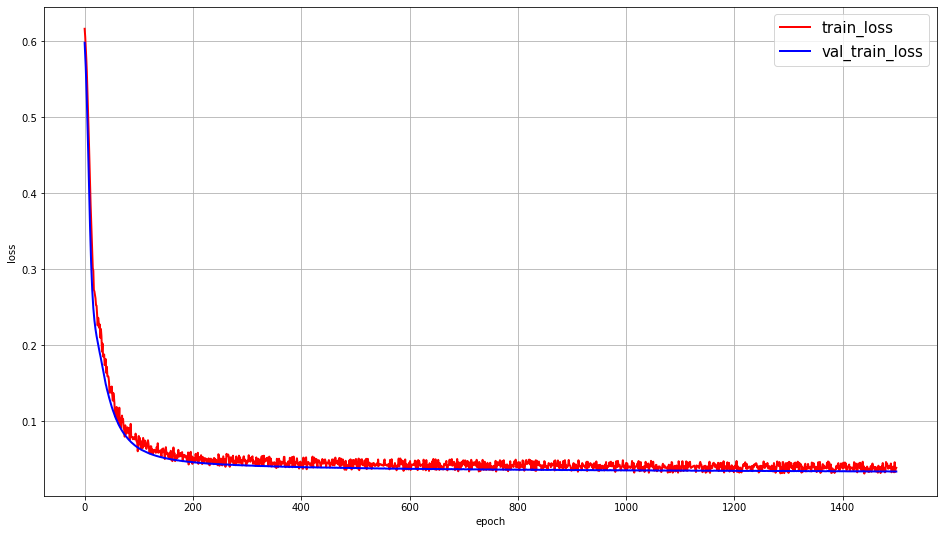

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(range(1500), loss_list, 'r', label='train_loss', linewidth=2)
plt.plot(range(1500), val_loss_list, 'b', label='val_train_loss', linewidth=2)
plt.legend(fontsize=15)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

In [ ]:
 model_path = "wl_model.pt"

model = MLP(4, 3)
model.load_state_dict(torch.load(model_path))
model.eval()

def eval_image(fname, thre):
    imw = IMW
    imh = IMH
    testx = np.zeros((0, 3, imh, imw), dtype=np.float32)

    a, img = load_image(fname, imw, imh)
    a1 = np.expand_dims(a,axis=0)
    #print(a1.shape)
    testx = np.append(testx, a1, axis=0)
    #print(testx.shape)
    #print(testx)

    import time
    t0 = time.time()
    testy = model(torch.FloatTensor(testx))
    #print(testy.shape)
    #testy = model.forward(testx)
    print('forward time [s]: ' + str(time.time()-t0))

    #fig, axs = plt.subplots(1,3)
    #plt.imshow(img, ax=axs[0])
    imd = Image.new('RGB', (imw*3, imh))
    
    ###
    #thimg_g = (testy.data[0][0]> thre)
    #thimg_g = thimg_g.astype(np.uint8)*255
    #thimg_w = (testy.data[0][1]> thre)
    #thimg_w = thimg_w.astype(np.uint8)*255

    thimg_g = (testy.to(cpu).detach().numpy()[0][0] > thre) * 255
    #print(thimg_g)
    thimg_w = (testy.to(cpu).detach().numpy()[0][1] > thre) * 255

    print(f'max {np.max(thimg_g)}')
    print(f'min {np.min(thimg_g)}')

    print(f'max {np.max(thimg_w)}')
    print(f'min {np.min(thimg_w)}')

    thimg_g = thimg_g.astype(np.uint8)
    #print(thimg_g.shape)
    thimg_w = thimg_w.astype(np.uint8)
    #print(thimg_w.shape)

    thimg_g = Image.fromarray(thimg_g).convert('L')
    thimg_w = Image.fromarray(thimg_w).convert('L')

    imd.paste(img, (0,0))
    imd.paste(thimg_g, (imw, 0))
    imd.paste(thimg_w, (imw*2, 0))
    plt.figure(figsize=(16,9))
    plt.imshow(imd)
    
    
    #imd.paste(img)
    #thimg = (testy.detach().to(cpu).numpy()[0][0] > thre) * 255
    #print(thimg.shape)
    #print(f'max {np.max(thimg)}')
    #rint(f'min {np.min(thimg)}')
    #thimg = thimg.astype(np.uint8)
    
    """
    thimg = Image.fromarray(thimg)
    plt.imshow(thimg)

    imd.paste(thimg, (imw, 0))
    plt.imshow(imd)
    imd = Image.new('RGB', (imw*2, imh))
    imd.paste(img)
    thimg = (testy.detach().to(cpu).numpy()[0][0] > thre) * 255
    print(thimg.shape)
    print(f'max {np.max(thimg)}')
    print(f'min {np.min(thimg)}')
    thimg = thimg.astype(np.uint8)
    
    thimg = Image.fromarray(thimg)
    plt.imshow(thimg)

    imd.paste(thimg, (imw, 0))
    plt.imshow(imd)
    """

forward time [s]: 0.004424333572387695
max 255
min 0
max 255
min 0


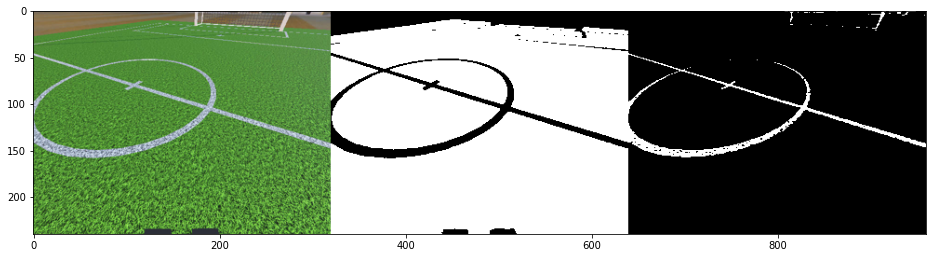

In [ ]:
#eval_image(os.path.join(Dataset_dir, test_img1), 0.5)
eval_image(test_img1, 0.5)

forward time [s]: 0.004364728927612305
max 255
min 0
max 255
min 0


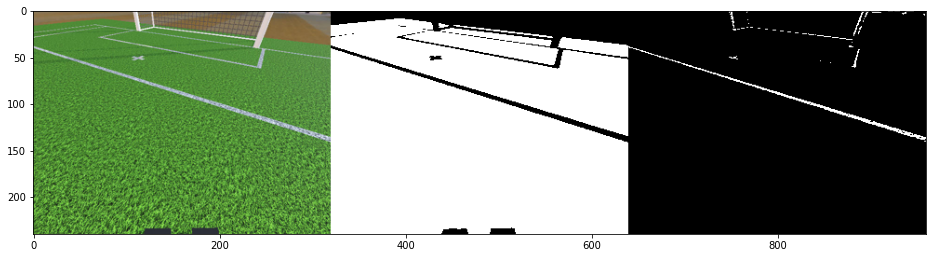

In [ ]:
eval_image(test_img2, 0.5)